In [1]:
#境界条件、強制力の作成

import numpy as np
import xarray as xr
import netCDF4
import MITgcmutils as mit
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from numba import njit
import MITgcmutils as mit
import cmocean 
from matplotlib.colors import Normalize # Normalizeをimport
from matplotlib.colors import TwoSlopeNorm
from geopy.distance import great_circle
import cartopy.crs as ccrs
import os
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

In [2]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# @njit(cache=True)
def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.array([lonlat_to_xyz(lon, lat) for lon, lat in flattened_XCYC1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

            # ノルムを計算（geopy を使用）
            for k in range(l):
                lon1, lat1 = XCYC1[top_l_indices[i, j, k, 0], top_l_indices[i, j, k, 1]]
                lon2, lat2 = XCYC2[i, j, 0], XCYC2[i, j, 1]

                top_l_norms[i, j, k] = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    return top_l_indices, top_l_norms

@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2.):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    l = top_l_indices.shape[2]  # 最近傍点の数
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) #when unit is deg, worked well.


    return regridded_data



In [3]:
#fileloc of bathymetry to use
# fileloc_bathy = '/home/tsuribeh/Forcing_data/bathymetries/Baatsen_2016/'
# fileloc_bathy = '/home/tsuribeh/Forcing_data/bathymetries/etopo1/'
fileloc_bathy = '/home/tsuribeh/Forcing_data/bathymetries/Straume_2020/'



#fileloc of forcing &inialstate data
fileloc_go_input = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/ETOPO1_global_ocean.cs32x15/input/'


In [4]:
# bathy_ds = netCDF4.Dataset(fileloc_bathy+'ETOPO1_Ice_g_gmt4.grd', 'r')
bathy_ds = xr.load_dataset(fileloc_bathy+'paleobathy-topo_40.00Ma_Straume_et_al.nc')
# bathy_ds = xr.load_dataset(fileloc_bathy+'baatsen_38Ma_Paleomag.nc')


bathy_ds

<xarray.Dataset> Size: 26MB
Dimensions:  (lon: 3601, lat: 1801)
Coordinates:
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
Data variables:
    z        (lat, lon) float32 26MB 887.3 887.3 887.3 ... -4.499e+03 -4.499e+03
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        
    history:      grdsample -R-180/180/-90/90 -I0.1 ../output/bathy_may19_40....
    description:  
    GMT_version:  5.4.5 [64-bit]

In [19]:
#make grid data of bathy(lonlat)
# c=1 #Baatsen every 0.5 deg.
# c =5 #Straume every 0.5 deg.
c =10 #Straume every  1deg.
# c =30 #ETOPO1 every 0.5 deg.
# c =60 #ETOPO1 every 0.05 deg.

# lon_ = np.array(bathy_ds['longitude'][::c])#Baatsen
# lat_ = np.array(bathy_ds['latitude'][::c])#Baatsen
lon_ = np.array(bathy_ds['lon'][::c])#Straume
lat_ = np.array(bathy_ds['lat'][::c])#Straume
# lon_ = np.array(bathy_ds.variables['x'][::c]) #ETOPO1
# lat_ = np.array(bathy_ds.variables['y'][::c]) #ETOPO1

lon,lat = np.meshgrid(lon_,lat_)
lonlat = np.stack([lon,lat],axis=2)

#loag raw bathy data
bathytopo_raw = np.array(bathy_ds['z'][::c,::c]).astype('float') #ETOPO,Straume
# bathytopo_raw = np.array(bathy_ds['Z'][::c,::c]).astype('float') #Baatsen

# mask_bathy_raw= bathy_raw > 0.
# bathy_raw[mask_bathy_raw] = np.nan
# bathy_raw[bathy_raw >0.] = np.nan


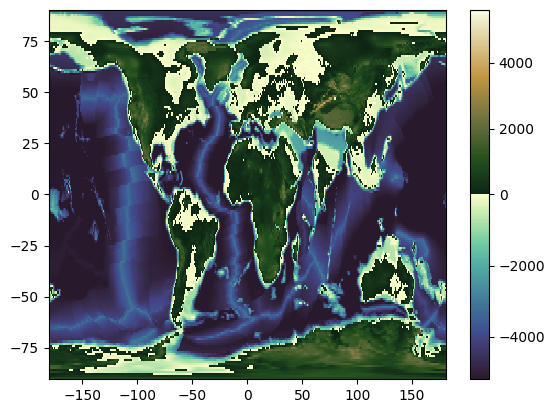

In [59]:
plt.pcolormesh(lon,lat,bathytopo_raw, cmap=cmocean.cm.topo, norm= TwoSlopeNorm(vcenter=0., vmin=-5200))
plt.colorbar()

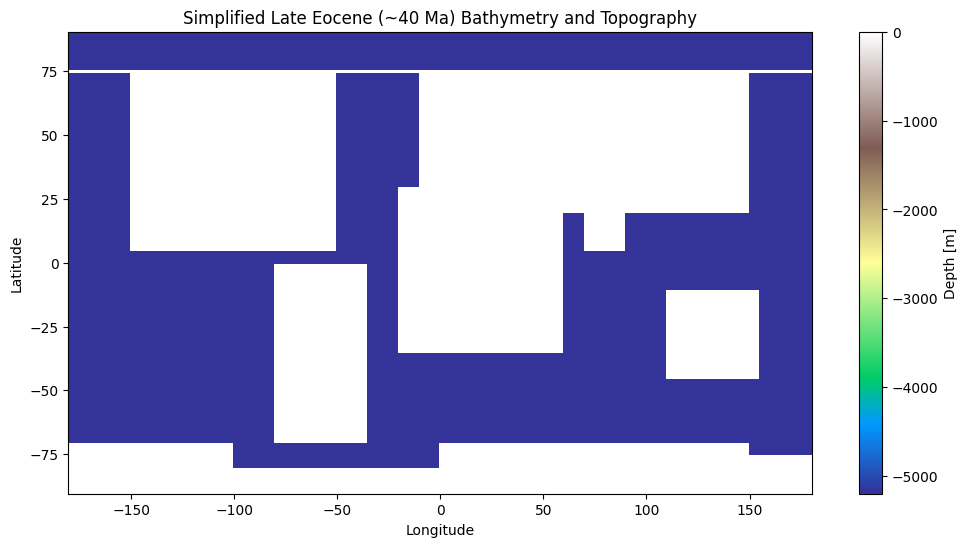

In [ ]:
simple_bathytopo = -5200 * np.ones_like(bathytopo_raw)

# 緯度・経度インデックスを簡単に参照できるように
def lat_index(val): return np.argmin(np.abs(lat_ - val))
def lon_index(val): return np.argmin(np.abs(lon_ - val))

# 南極大陸（南緯70度以南）
simple_bathytopo[:lat_index(-70), :] = 0

# ウェッデル海（南緯80度以南、経度 -100 〜 0）
simple_bathytopo[lat_index(-80):, lon_index(-100):lon_index(0)] = -5200

# ロス海（南緯75度以南、経度150度以東）
simple_bathytopo[lat_index(-75):, lon_index(150):] = -5200

# 北極周辺（北緯75度以北）
simple_bathytopo[lat_index(75), :] = 0

# 北アメリカ（緯度5〜75度、経度 -150〜-50）
simple_bathytopo[lat_index(5):lat_index(75), lon_index(-150):lon_index(-50)] = 0

# 南アメリカ（緯度-70〜0度、経度 -80〜-35）
simple_bathytopo[lat_index(-70):lat_index(0), lon_index(-80):lon_index(-35)] = 0

# ユーラシア（緯度20〜75度、経度 -10〜150）
simple_bathytopo[lat_index(20):lat_index(75), lon_index(-10):lon_index(150)] = 0

# アフリカ（緯度 -35〜30度、経度 -20〜60）
simple_bathytopo[lat_index(-35):lat_index(30), lon_index(-20):lon_index(60)] = 0

# オーストラリア（緯度 -45〜-10度、経度 110〜155）
simple_bathytopo[lat_index(-45):lat_index(-10), lon_index(110):lon_index(155)] = 0

# インド（緯度 5〜30度、経度 70〜90）
simple_bathytopo[lat_index(5):lat_index(30), lon_index(70):lon_index(90)] = 0






plt.figure(figsize=(12, 6))
plt.pcolormesh(lon_, lat_, simple_bathytopo, shading='auto', cmap='terrain')
plt.colorbar(label='Depth [m]')
plt.title("Simplified Late Eocene (~40 Ma) Bathymetry and Topography")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [39]:
#Directory for cs grid
fileloc_csgrid = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/cpl_aim+ocn_cs32/rank_1/'
# CSグリッドデータの読み込み
XC = mit.mds.rdmds(fileloc_csgrid+'XC') #longitude at cell center
YC = mit.mds.rdmds(fileloc_csgrid+'YC') #latitude at cell center
XG = mit.mds.rdmds(fileloc_csgrid+'XG')
YG = mit.mds.rdmds(fileloc_csgrid+'YG')
# RC = mit.mds.rdmds(fileloc_csgrid+'RC')  # セル中心の深さ can be changed
# RF = mit.mds.rdmds(fileloc_csgrid+'RF')  # セル境界の深さ can be changed


XCYC = np.stack([XC,YC],axis=2)
XGYG = np.stack([XG,YG],axis=2)

#compute indice and norm for regridding
top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=9)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=9)


In [276]:
fileloc_ocn='/home/tsuribeh/MITgcm/cases_tsuribeh_master/CNTL_test/input_ocn/'
fileloc_atm='/home/tsuribeh/MITgcm/cases_tsuribeh_master/CNTL_test/input_atm/'
fileloc_cpl='/home/tsuribeh/MITgcm/cases_tsuribeh_master/CNTL_test/input_cpl/'



In [52]:
#海洋地形データの作成
filename_bathy = 'bathy.CNTL5200_CS32.bin'
# bathy_raw= bathytopo_raw.copy()
bathy_raw= simple_bathytopo.copy()

bathy_raw[bathy_raw>=-0.] = np.nan

# bathy_raw[bathytopo_raw<-0.] = -5200.




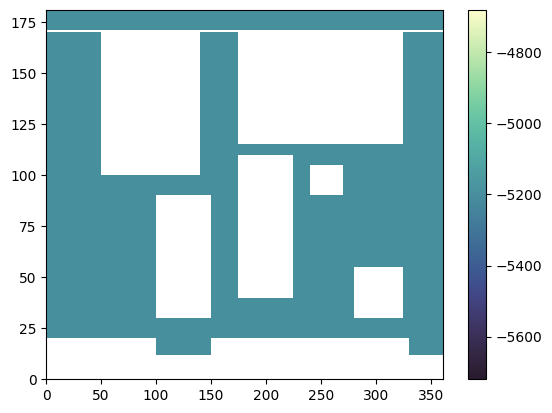

In [53]:
plt.pcolormesh(bathy_raw, cmap=cmocean.cm.deep_r#, vmax=0. 
               ,vmin=-5200
               )
plt.colorbar()

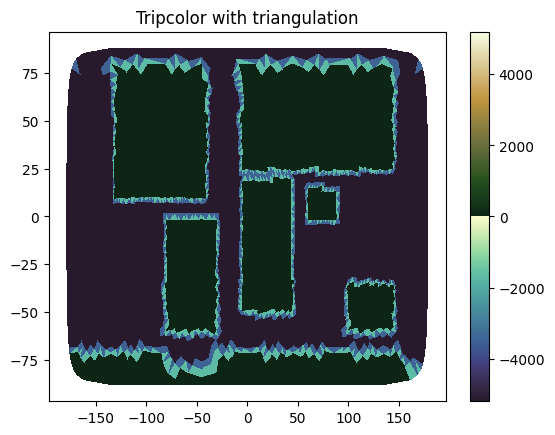

In [54]:
# bathy_data = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathy_raw,p=2.)
bathy_data = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathy_raw,p=2.)

bathy_data[np.isnan(bathy_data)]= 0. 
bathy_data[(bathy_data<0.) & (bathy_data>-20.)]= -20. #最も浅い部分が50m(1層目) 

# 1DにflattenされたX, Y, 値（Z）
x = XC.flatten()
y = YC.flatten()
z = bathy_data.flatten()

# Delaunay三角分割を作成
triang = tri.Triangulation(x, y)

# プロット
plt.figure()
plt.tripcolor(triang, z, cmap=cmocean.cm.topo,shading='flat', norm=TwoSlopeNorm(vcenter=0.,vmin=-5200))  # or shading='gouraud'
plt.colorbar()
plt.title("Tripcolor with triangulation")
plt.show()


In [293]:

mit.writebin(fileloc_ocn+filename_bathy, bathy_data)

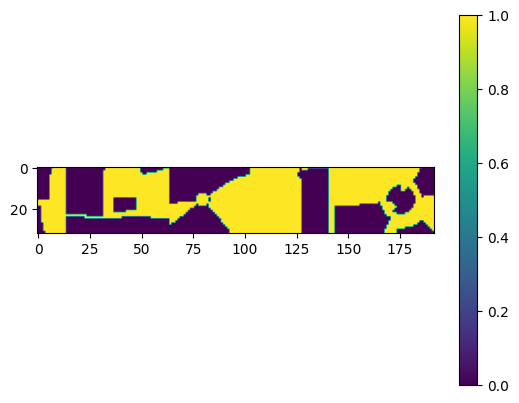

In [55]:
mask_ocn=np.where(bathy_data==0., 0.,1.)
plt.imshow(mask_ocn)
plt.colorbar()

In [296]:
#海洋初期水温場の作成
filename_ocniniT = 'iniT.CNTL5200_CS32_15k.bin'
iniT_data = np.ones((15,32,192))*5.  * mask_ocn#5度とする

mit.writebin(fileloc_ocn+filename_ocniniT, iniT_data)

In [297]:
#海洋初期塩分場の作成
filename_ocniniS = 'iniS.CNTL5200_CS32_15k.bin'
iniS_data = np.ones((15,32,192))*33. * mask_ocn
mit.writebin(fileloc_ocn+filename_ocniniS, iniS_data)

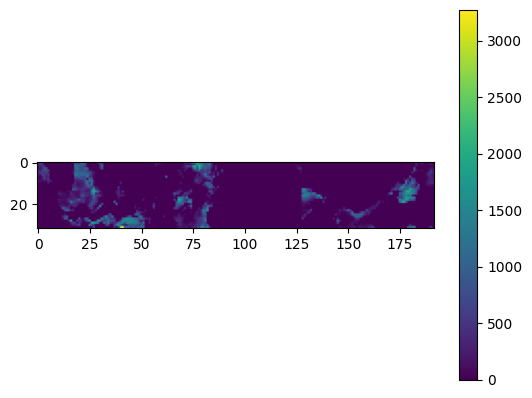

In [298]:
#大気地形データの作成
filename_bathy = 'topo.CNTL5200_CS32.bin'

bathytopo_data = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathytopo_raw,p=2.)

topo_data = bathytopo_data.copy()
topo_data[bathy_data != 0.] =0.
topo_data[(bathy_data ==0. )& (topo_data<=0.)] =1.e-2
plt.imshow(topo_data)
plt.colorbar()
mit.writebin(fileloc_atm+filename_bathy, bathy_data)

In [299]:
np.unique(topo_data)

array([0.00000000e+00, 1.00000000e-02, 2.77208543e-02, ...,
       2.75412742e+03, 2.87009007e+03, 3.27159933e+03])

In [300]:
np.where((bathy_data==0.) & (topo_data==0.))

(array([], dtype=int64), array([], dtype=int64))

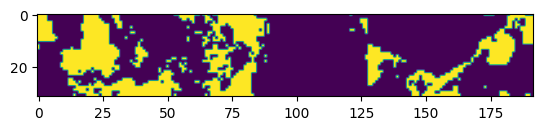

In [301]:
#land maskの作成
filename_landmask = 'landmask.CNTL5200_CS32.bin'
landmask_data = 1. - mask_ocn
plt.imshow(landmask_data)
mit.writebin(fileloc_atm+filename_landmask, landmask_data)


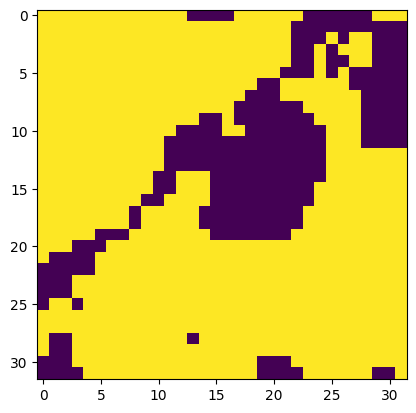

In [306]:
plt.imshow(mask_ocn[:,-32:])


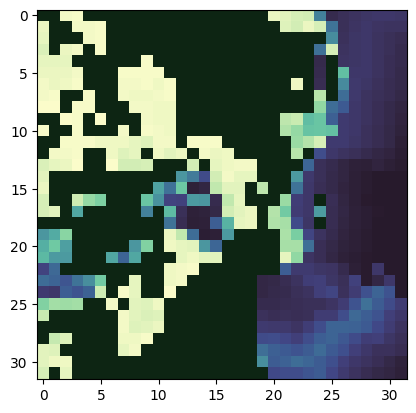

In [312]:
plt.imshow(bathy_data[:,64:96],cmap=cmocean.cm.topo, norm=TwoSlopeNorm(vcenter=0., vmin=-5200.))

In [303]:
np.where((bathy_data==0.) & (landmask_data == 0.))


(array([], dtype=int64), array([], dtype=int64))

In [304]:
rO0 = np.empty((0,3))
filename_runOff = 'runOff.AP5200_CS32.bin'
mit.writebin(fileloc_cpl+filename_runOff, rO0, dataprec='float64')